# MsFEM: Offline Space

In [1]:
import numpy as np
from ufl import *
from scipy.linalg import eigh
from scipy.sparse import csr_matrix
from dolfin import *

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
n_el = 32

mesh = UnitSquareMesh(n_el, n_el)
V = FunctionSpace(mesh,'P',1)
bmesh = BoundaryMesh(mesh, "exterior", True)

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [3]:
tol = 1 / n_el
def boundary_1(p, src):
        predicat_1 = near(p[0], src[0], tol)
        predicat_2 = near(p[1], src[1], tol)

        return predicat_1 & predicat_2
        
def boundary_2(x, src, on_boundary):
    return on_boundary and not boundary_1(x, src)

In [33]:
U, DU = [], []
alpha = (1. / tol) ** 2

CNT  = 0
stop = None
prev = None
cumul = []
check = False

kappa = 1.


_u = TrialFunction(V)
_v = TestFunction(V)

a = kappa * dot(grad(_u), grad(_v)) * dx
L = Constant(0.) * _v * dx

for src in bmesh.coordinates():
    pn = lambda x, on_boundary: \
        boundary_2(x, src, on_boundary)
    bc2 = DirichletBC(V, Constant(0.), pn)
    
    pt = lambda x: boundary_1(x, src)

    u_bc = Constant(1.)
    bc1 = DirichletBC(V, u_bc, pt)

    bc = [bc1, bc2]
    
    if check:
        _u = TrialFunction(V)
        _v = TestFunction(V)
        a = dot(grad(_u), grad(_v)) * dx
    # ^^^^^ check that matrix A does not change
        curr = assemble(a).array()
        if prev is not None:
            to_add = np.allclose(curr, prev)
            if not to_add:
                print("'A' has changed")
                break
            cumul.append(to_add)

        prev = curr            
    # ^^^^^ ------------------------------------
    
    u = Function(V)

    solve(a == L, u, bc)
    U.append(u)
    DU.append(grad(u))
    
    # early stop (to plot the chosen solution)
    CNT += 1
    if stop and CNT >= stop:
        break

In [30]:
build = np.vectorize(assemble)
A = build(np.outer(U, U) * dx)
S = build(np.tensordot(DU, DU, [1, 1]) * dx)

In [31]:
w, v = eigh(A, S)
w /= w[-1]

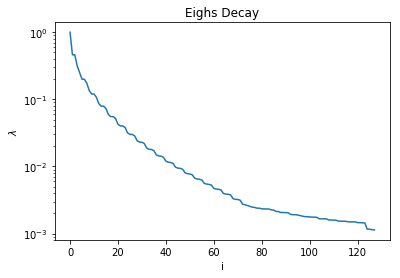

In [32]:
plt.plot(w[::-1])
plt.title("Eighs Decay")
plt.ylabel(r'$\lambda$');
plt.yscale('log')
plt.xlabel('i');

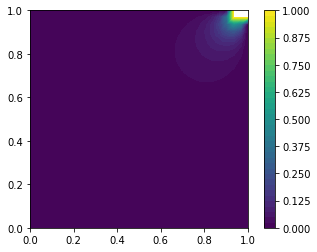

In [67]:
# plot the solution specified by 'stop'
# or for the last bcs, otherwise
p = plot(u)
plt.colorbar(p);

**Eigenfunctions**

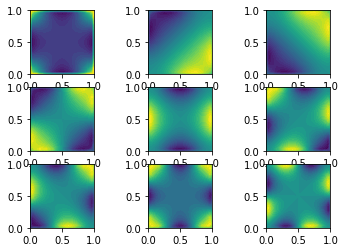

In [86]:
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plot(np.dot(U, v[:, -i]));

# Draft

```python
tol = 5e-3
def boundary_1(x, src):
    return (src[0] - x[0]) ** 2 + (src[1] - x[1]) ** 2 <= tol

def boundary_2(x, src):
    return (src[0] - x[0]) ** 2 + (src[1] - x[1]) ** 2  > tol
```

```python
tol = 1 / n_el
def boundary_1(p, src):
    for vx, vy in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        if near(src[0], vx) and near(src[1], vy):
            predicat_1 = near(p[0], src[0], tol)
            predicat_2 = near(p[1], src[1], tol)
            
            return predicat_1 & predicat_2
        
    for xy, tb in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        if near(src[xy], tb):
            predicat_1 = near(p[xy], tb)
            predicat_2 = near(p[1-xy], src[1-xy], tol)

            return predicat_1 & predicat_2
        
def boundary_2(x, src, on_boundary):
    return on_boundary and not boundary_1(x, src)
```

```python
tol = 1 / n_el
k_0 = 100.
k_1 = .01
kappa = Expression(
    "(((.4 < x[0]) && (x[0] < .5)) && "
    "((.5 < x[1]) && (x[1] < .6))) ? k_0: k_1", 
    degree=0, tol=tol, k_0=k_0, k_1=k_1
)
    
#add to block with for loop if switch to smooth boundaries
"""u_bc = Expression(
    'alpha * exp(-1. / (1 - alpha * ((x[0] - x_0) * '
    '(x[0] - x_0)+ (x[1] - x_1) * (x[1] - x_1))))',
    degree=2, alpha = alpha, x_0 = src[0], x_1 = src[1]
)"""
```

In [204]:
nodal_values_u = u.vector()
array_u = nodal_values_u.get_local()

In [130]:
tmp = mesh.coordinates().reshape(n_el + 1, -1 , 2)

win = n_el // 16
subarea = tmp[win : -win, win : -win]
side = n_el + 1 - 2 * win

n_strips = n_el // 3
span = np.random.choice(side, 2 * n_strips).reshape(-1, 2)
span = np.clip(np.sort(span) + [-1, 1], 0, side-1)

xory = np.random.choice(side, n_strips)
rv = np.random.binomial(1, .5, n_strips)

mask = np.zeros((side, side), dtype=int)

for r, pos, (a, b) in zip(rv, xory, span):
    if r:
        mask[a:b, pos] = 1
    else:
        mask[pos, a:b] = 1

[ 0  1  2  3  3  3  3  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7  7  8  8
  8  8  9  9  9 10 10 10 11 12]
[6 6 6 3 4 5 6 7 8 9 0 1 6 0 1 6 0 1 6 0 1 5 6 0 1 5 6 0 1 6 0 1 6 1 1]


In [9]:
tmp = as_backend_type(assemble(a)).mat()
S = csr_matrix(tmp.getValuesCSR()[::-1], shape=tmp.size)